# IMDB (Movie Review )
Identify if reviews are negative or positive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

## Preparing the data

In [20]:
path = untar_data(URLs.IMDB_SAMPLE) # First let's download the dataset
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv'),
 PosixPath('/root/.fastai/data/imdb_sample/data_save.pkl')]

It only contains one csv file, let's have a look at it.

In [21]:
df = pd.read_csv(path/'texts.csv') # this data contains a total of 100,000 reviews on IMDB
df.head() # with labels of either negative or positive 

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [22]:
df['text'][1] ## example of the data 

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

In [23]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv') # If we ignore the flag(validation or training set), we can create a DataBunch containing this data in one line of code

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

In [0]:
data_lm.save() # save the things that were calculated.

Next time we launch this notebook, we can skip the cell above that took a bit of time 

In [0]:
data = load_data(path) # load those results like this

### Tokenization

In [26]:
data = TextClasDataBunch.from_csv(path, 'texts.csv') # In texts.csv, the raw sentences split  into words, or more exactly tokens
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

In [27]:
data.vocab.itos[:10] # we convert tokens to integers by creating a list of all the words used.
# The correspondance from ids to tokens is stored in the vocab attribute of our datasets, in a dictionary called itos (for int to string). 

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [28]:
data.train_ds[0][0] # the tokenized text as a representation

Text xxbos i thought the original of this film was quaint and charming as well as having me sitting on the edge of my seat trying to figure it out . 
 
  xxmaj since i had already seen the original , when i saw this on xxmaj sci xxmaj fi xxmaj xxunk i do n't know if this remake was deliberately made for xxmaj sci xxmaj fi - i knew what it was within the first few minutes . xxmaj since i like xxmaj richard xxmaj burgi as a character actor , i wanted to see how he would pull it off . 
 
  xxmaj the writers / producers etc , xxunk the film a bit by trying to explain the plight of the " aliens " ( xxmaj they could no longer xxunk their own kind and needed help ) using the same pseudo science that has been xxunk in our ears in the 90 's . xxmaj maybe it added a bit of polish to the film , or not . 
 
  xxmaj this film . xxmaj film ? xxmaj this production takes on a more sinister edge than the original xxunk xxmaj the original ended with a confrontation between the young woman and the alien 

In [29]:
data.train_ds[0][0].data[:10] # we can see that the underlying data is all numbers

array([   2,   19,  213,    9,  219,   14,   21,   32,   26, 4678])

### With the data block API

In [30]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch()) # manually call the tokenize and numericalize steps

## Language model

In [0]:
bs=48 # language models can use a lot of GPU, so decrease batchsize

In [32]:
path = untar_data(URLs.IMDB) # grab the full dataset for what follows.
path.ls()

[PosixPath('/root/.fastai/data/imdb/data_lm.pkl'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas')]

In [33]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/neg')]


We're not going to train a model that classifies the reviews from scratch, but use a model pretrained on a bigger dataset. 

We will use a cleaned subset of wikipedia called wikitext-103 

Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit.

In [34]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) # unlabelled data  to fine-tune our model
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

`TextDataBunch` ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs) #  load quickly the final ids by using the following cell.

In [36]:
data_lm.show_batch()

idx,text
0,me the most was the long lasting storyline that kept going even when you thought i would end but a small downside is the xxmaj multiplayer . \n \n xxmaj the xxup mp is good the weapons and maps are good it 's just the fact that the amount of people playing is small and if someone lags everyone else does . \n \n xxmaj the xxmaj single
1,are dragged to the xxmaj zombification chamber . xxmaj they boys heroically do nothing till it 's too late . xxmaj the xxmaj sheriff arrives and turns out to have been a baddie all along . xxmaj one of the spies shoots him and while xxmaj ivan is disposing of the body the boys make their move . xxmaj after the the weirdest rolling around on the floor fighting ever
2,"! i visited him in xxmaj hawaii in 1986 and lost touch afterwords and remember his discussions of how the locals there treated him differently as a ' xxmaj xxunk ' ( xxmaj eric 's mother is full blood xxmaj asian , although she grew up in the same neighborhood with his father in the xxup u.s. ) xxmaj anyway , it is no surprise to me that xxmaj eric"
3,"only imagine the pitch the writer made to the studios : "" xxmaj it 's like xxmaj saw / xxmaj seven mixed with the xxmaj davinci xxmaj code ! "" . xxmaj except with even worse writing : \n \n xxmaj quaid : "" xxmaj he made 4 rigs . xxmaj we got 2 victims "" . \n \n xxmaj detective who looks like xxmaj chuck xxmaj berry"
4,"expecting a much better film , never mind better cinematography . xxmaj but it 's slow , tired and worn . xxmaj the trailer was a better film than the movie ... it moved , it had action and it left you wanting more . \n \n xxmaj the story starts off slowly , and never seems to really reach the speed you wish it would attain . xxmaj"


In [37]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3) #  loaded with the pretrained weights.

In [38]:
learn.lr_find() # find learning rate 

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


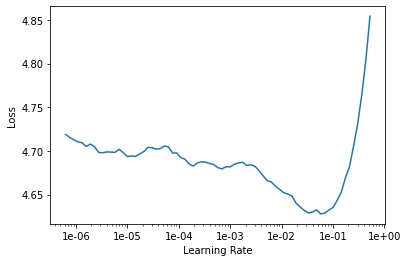

In [39]:
learn.recorder.plot(skip_end=15) # and plot it

In [40]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7)) # train the model 

epoch,train_loss,valid_loss,accuracy,time
0,4.134200,4.029713,0.295008,25:59


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

In [0]:
learn.unfreeze() # unfeeze and launch a new training.

In [0]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.863410,3.848879,0.312944,26:22


In [0]:
learn.save('fine_tuned')

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "I liked this movie because"  # text to test the model
N_WORDS = 40
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES))) ## predict

In [0]:
learn.save_encoder('fine_tuned_enc') # save encoder, the part that's responsible for creating and updating the hidden state

## Classifier

In [0]:
path = untar_data(URLs.IMDB) # grabs the labelled data 

In [0]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [0]:
data_clas.show_batch()

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5) # model to classify those reviews and load the encoder we saved before.
learn.load_encoder('fine_tuned_enc')

In [0]:
learn.lr_find()

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

In [0]:
learn.save('first')

In [0]:
learn.load('first');

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [0]:
learn.save('third')

In [0]:
learn.load('third');

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [0]:
learn.predict("I really loved that movie, it was awesome!")